In [16]:
import numpy as np
import pandas as pd
import os
import zipfile
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from IPython.display import display
import random

# define Seaborn color palette to use
# colors = sns.color_palette("hls", 8)
colors = sns.color_palette("crest", 8)
cmap_colors = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

# define the fig size of all figures
plt.rcParams["figure.figsize"] = (10,6)
# the directory to unzip the data in
data_directory_path = r"C:\Users\ADMIN\Desktop\Varun\Varun Thesis"

# Converting the days and hours from numbers to their interpretable form
days_of_week = {0: 'Saturday', 
                1: 'Sunday', 
                2: 'Monday',
                3: 'Tuesday',
                4: 'Wednesday',
                5: 'Thursday',
                6: 'Friday'}
hour_nums = list(range(24))
hours_of_day = {hour_num:datetime.time(hour_num).strftime("%I:00 %p") for hour_num in hour_nums}


In [17]:
# Unziping all dataset tables. Placing unzipped files in /kaggle/working/dataset directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        with zipfile.ZipFile(os.path.join(dirname, filename), 'r') as zip_ref:
            zip_ref.extractall(data_directory_path)

In [18]:
''' 
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
'''
def reduce_mem_usage(train_data):
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype
        
        if col_type not in [object, 'category']:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')
    end_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data

# Annotate text on graph
def annotate_text(p, append_to_text='%'):
    for p in ax.patches:
        txt = str(p.get_height().round(2)) + append_to_text
        txt_x = p.get_x() + p.get_width()/2.
        txt_y = 0.92*p.get_height()
        ax.text(txt_x,txt_y,txt, fontsize=20, color='#004235', ha='center', va='bottom')

In [19]:
# Reading the csv files into corresponding dataframes
# Then reduce their size to consume less memory
aisles = pd.read_csv('aisles.csv')
#aisles = reduce_mem_usage(aisles)

departments = pd.read_csv('departments.csv')
#departments = reduce_mem_usage(departments)

order_products_prior = pd.read_csv('order_products__prior.csv')
#order_products_prior = reduce_mem_usage(order_products_prior)

order_products_train = pd.read_csv('order_products__train.csv')
#order_products_train = reduce_mem_usage(order_products_train)

orders = pd.read_csv('orders.csv')
# Replacing numbers with their corresponding hour representation
orders['order_hour_of_day'] = orders['order_hour_of_day'].replace(to_replace=hours_of_day, value=None)
orders['order_hour_of_day'] = pd.Categorical(orders['order_hour_of_day'], 
                                             ordered=True, 
                                             categories=list(hours_of_day.values()))
# Replacing numbers with their corresponding day of week
# Define the categories of days of week sorted normally from Saturday to Friday
orders['order_dow'] = orders['order_dow'].replace(to_replace=days_of_week, value=None)
orders['order_dow'] = pd.Categorical(orders['order_dow'], 
                                     ordered=True, 
                                     categories=list(days_of_week.values()))
#orders = reduce_mem_usage(orders)

products = pd.read_csv('products.csv')
#products = reduce_mem_usage(products)

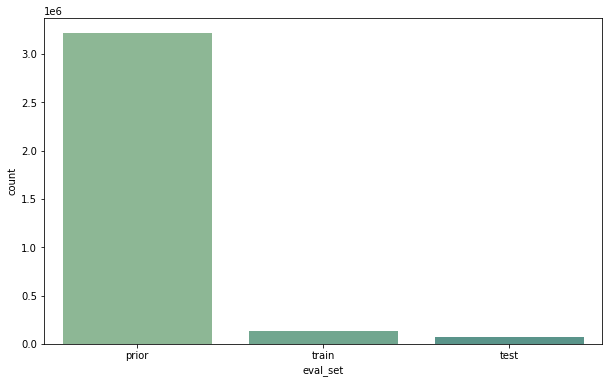

In [20]:
# Count of prior, train, test orders given in the data
sns.countplot(x='eval_set', data=orders, palette=colors)
plt.show()

In [ ]:
# Merging the Prior and train order_products
Final_df = pd.concat([order_products_train, order_products_prior])
Final_df = Final_df.merge(products, on='product_id', how='left').merge(orders, on='order_id', how='left').merge(departments, on='department_id').merge(aisles, on='aisle_id')

# Count of total orders
total_orders = Final_df['order_id'].nunique()
print('Count of total orders: ', total_orders)

print('Merging products, order_products, and orders tables...')

Final_df.head()

In [ ]:
Final_df.info()

In [ ]:
Final_df.shape

In [ ]:
##Unique rows of the Data
print("Number of unique rows:\n",Final_df.nunique())

In [ ]:
Final_df.columns